In [2]:
import os
import enum
import csv, re
from collections import Counter
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
#unknown regex: unknown|^\?+$|don'?t know|idk|forg[oe]t|unsure|no idea

plt.style.use('seaborn')

plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.grid'] = False
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.facecolor'] = 'white'

P_DATAFILE = './data/posts-pared.csv'
C_DATAFILE = './data/pushshift/tipofmyjoystick_comment_1640934644.csv'
PLATFORM_FILE = 'platformsRegex.csv'
YEAR_FILE = 'yearsRegex.csv'

START_DATE = '2012-10'
END_DATE = '2022'

MAX_SCORE = 300
MAX_LENGTH = 4000
MAX_COMMENTS = 121

P_COLUMNS = (
    'ID',
    'TITLE',
    'USER',
    'TEXT',
    'FLAIR',
    'DATE',
    'SCORE',
    'NUM_COMMENTS',
    'NSFW',
    'LENGTH',
    'FOLLOWS_FORMAT',
    'SOLVED',
)

C_COLUMNS = (
    'ID',
    'USER',
    'DATE',
)

PF = enum.IntEnum('PF', P_COLUMNS, start=0)
CF = enum.IntEnum('CF', C_COLUMNS, start=0)

## Helper Functions

In [4]:
def sanitizeFile(filename):
    with open(filename, encoding='utf-8') as f:
        raw = f.read()
    
    sanitized = raw.replace("’", "'")
    
    with open(filename, 'w', encoding='utf-8') as f:
        f.write(sanitized)


def str2bool(s):
    return True if s == 'True' else False


# Makes x ticks only for each year
def xtickDates(data, ax):
    ax.tick_params(
        axis='x', direction='out', which='major',
        length=3, width=1)
    
    years = []
    for i, dateRange in enumerate(data.index):
        date = dateRange.right
        if date.month == 1:
            years.append((date.year, i-0.5))
    
    xlabels, xticks = list(zip(*years))
    
    plt.xticks(xticks, xlabels, rotation=0)

    
# Used for plotting missing data
def getDateIndices(missing, data):
    missingIndices = []
    for i, dateRange in enumerate(data.index):
        date = dateRange.right
        for year, month in missing:
            if date.year == year and date.month == month:
                missingIndices.append(i)
                
    return missingIndices

## Analyzing Classes

In [5]:
class PostAnalyzer():
    def __init__(self, logging=False):
        self.logging = logging
        
        self.weirdPlatforms = Counter()
        self.weirdYears = Counter()
        self.numsBinned = dict()
        self.comparedBoolBool = dict()
        
        self.getRegex()
        self.loadBins() # score: {all:..., solved:..., nsfw:...}, ...
        self.loadData()

    
    def loadData(self):
        self.data = pd.read_csv(P_DATAFILE, names=P_COLUMNS, parse_dates=[PF.DATE])
        
        print(self.data)

    
    # Gets bins for different data types
    def loadBins(self):
        def getSomeBinsLog(maximum, numBins):
            bins = np.logspace(0, np.log10(maximum), numBins+1).astype(int)
            bins[0] = -1 # So we get 0 included
            bins = np.insert(bins, 1, 0)
            return bins
            
        self.bins = dict()
        
        # Date
        self.bins['DATE'] = pd.date_range(START_DATE, END_DATE, freq='M')
        
        # Score
        self.bins['SCORE'] = getSomeBinsLog(MAX_SCORE, 14)
        
        # Length
        self.bins['LENGTH'] = np.arange(0, MAX_LENGTH+1, 100).astype(int)
        
        # Num comments
        self.bins['NUM_COMMENTS'] = getSomeBinsLog(MAX_COMMENTS, 13)
    
    
    # Plots a probability mass distribution
    def plotPMFHist(self, dataType):
        fig = plt.figure()
        ax = fig.add_subplot(111)

        hist, bins = np.histogram(self.data[dataType], bins=self.bins[dataType]+1)
        width = bins[1] - bins[0]
        ax.bar(bins[:-1] + width/2, hist / hist.sum(), width=width)
        return ax

    
    # Get list of all platforms and years (decade ranges)
    # This was first suggested on 2021-1-24 and mandated 2020-4-15
    def getAllPlatformsYears(self):
        self.platformsCount = Counter()
        self.yearsCount = Counter()
        
        self.platformsSolved = Counter()
        self.yearsSolved = Counter()

        for platform in self.allPlatforms:
            self.platformsCount[platform] = 0
            self.platformsSolved[platform] = 0
        for year in self.allYears:
            self.yearsCount[year] = 0
            self.yearsSolved[year] = 0
        
        self.debugL = []
        
        [self.addPlatformYear(row[0].lower(), row[1])
            for row in zip(
                self.data.TITLE, 
                self.data.SOLVED,
            )]
        
        # Converts normal and solved counts into dataframe
        def countsToDF(normal, solved, allTags):
            get1stIndex = lambda L: L[0]
            n = len(allTags)
            parts = []
            for part in [normal, solved]:
                parts.append(sorted(list(part.items()), key=get1stIndex))
            allCounts = [(parts[0][i][1], parts[1][i][1]) for i in range(n)]
            return pd.DataFrame(allCounts, index=allTags, columns=['ALL', 'SOLVED'])
        
        self.platforms = countsToDF(self.platformsCount, self.platformsSolved, self.allPlatforms)
        self.years = countsToDF(self.yearsCount, self.yearsSolved, self.allYears)
        
        # Removes unknown label, since we don't care about it
        self.platforms = self.platforms.drop(index='Unknown')
        self.years = self.years.drop(index='Unknown')
        
        self.platforms['SOLVED_F'] = self.platforms['SOLVED'] / self.platforms['ALL']
        self.years['SOLVED_F'] = self.years['SOLVED'] / self.years['ALL']
        
        self.platforms['SOLVED%'] = self.platforms['SOLVED_F'] * 100
        self.years['SOLVED%'] = self.years['SOLVED_F'] * 100
        
        self.platforms.sort_values(by='SOLVED%', ascending=False, inplace=True)
        #self.years.sort_values(by='SOLVED%', ascending=False, inplace=True)


    # Extract platform and year from a title
    def addPlatformYear(self, title, solved):
        bracketed = re.findall('\[.*?\]', title)
        bracketed = [match[1:-1] for match in bracketed]

        # Only check for year and platform if the post uses the format
        if len(bracketed) == 2:
            platform, weirdPlatform = self.getBracketed(bracketed[0], self.platformsRegex)
            year, weirdYear = self.getBracketed(bracketed[1], self.yearsRegex)

            # Deal with flipped year/platform
            if (platform == set()) and (year == set()):
                platform, weirdPlatform = self.getBracketed(bracketed[1], self.platformsRegex)
                year, weirdYear = self.getBracketed(bracketed[0], self.yearsRegex)

            # DEBUG
            if 'SEGA Console' in platform:
                self.debugL.append(title)
            # End DEBUG
            
            self.platformsCount.update(platform)
            self.yearsCount.update(year)
            if solved:
                self.platformsSolved.update(platform)
                self.yearsSolved.update(year)

            if weirdPlatform:
                self.weirdPlatforms[weirdPlatform] += 1
            if weirdYear:
                self.weirdYears[weirdYear] += 1


    # Load regexes from files
    def getRegex(self):
        def getSomeRegex(filename):
            filename = os.path.join('./regex/', filename)
            with open(filename, encoding='utf-8-sig', newline='') as f:
                reader = csv.reader(f)
                regex = []
                for row in list(reader):
                    pattern = row[0]
                    tags = [platform for platform in row[1:] if platform != '']
                    regex.append((pattern, tags))
                return regex

        self.platformsRegex = getSomeRegex(PLATFORM_FILE)
        self.yearsRegex = getSomeRegex(YEAR_FILE)
        
        # Converts regex and gets all tags
        def getAllTagsFromRegex(regex):
            allTags = []
            for pattern, tags in regex:
                for tag in tags:
                    if tag not in allTags:
                        allTags.append(tag)
            allTags.sort()
            return allTags
        
        self.allPlatforms = getAllTagsFromRegex(self.platformsRegex)
        self.allYears = getAllTagsFromRegex(self.yearsRegex)


    # Uses platform regexes to see which are in a given title
    def getBracketed(self, text, regex):
        results = set()
        weirdResult = ''

        for pattern, tags in regex:
            if re.search(pattern, text) is not None:
                results.update(tags)

        # Text not found in any regex
        if not results:
            weirdResult = text

        return results, weirdResult
    
    
    # Computes some boolean value vs a numeric value
    def compareBoolNum(self, boolVal, numVal):
        # For some label and which data counts, get the distribution
        def getSingleNumeric(val, counting):
            counting = counting[numVal]
            counting = pd.cut(counting, bins)
            self.numsBinned[numVal][val] = counting.value_counts(sort=False)
            
        bins = self.bins[numVal]
        
        # Initialize the distribution for the entire set if it hasn't already been done
        if numVal not in self.numsBinned.keys():
            self.numsBinned[numVal] = dict()
            getSingleNumeric('ALL', self.data)
            
        getSingleNumeric(boolVal, self.data[self.data[boolVal] == True])
        # A fraction of (boolVal == True)/total
        self.numsBinned[numVal][boolVal+'_F'] = self.numsBinned[numVal][boolVal] / self.numsBinned[numVal]['ALL']
        self.numsBinned[numVal][boolVal+'%'] = self.numsBinned[numVal][boolVal+'_F'] * 100
    
    
    # Compare two boolean variables in a 2x2 table
    def compareBoolBool(self, depVar, indVar):
        if depVar not in self.comparedBoolBool.keys():
            self.comparedBoolBool[depVar] = dict()
        
        comparing = pd.crosstab(self.data[indVar], self.data[depVar], normalize='index')
        self.comparedBoolBool[depVar][indVar] = comparing.reindex(index=[True, False], columns=[True, False])
        
    
    def analyze(self):
        self.getAllPlatformsYears()
        
        boolNumVals = [
            ('SOLVED', ('DATE', 'SCORE', 'LENGTH', 'NUM_COMMENTS')),
            ('NSFW', ('SCORE',))
        ]
        
        for boolVal, numVals in boolNumVals:
            for numVal in numVals:
                self.compareBoolNum(boolVal, numVal)
        
        self.compareBoolBool('SOLVED', 'FOLLOWS_FORMAT')
        self.compareBoolBool('SOLVED', 'NSFW')

        
pa = PostAnalyzer()
pa.analyze()

            ID                                              TITLE  \
0       rqxfd8                 [PC][2000's] "Night of Lycan Rock"   
1       rqxcp1  [PC][2010S] A horror game where you play a gir...   
2       rqx1lw  [PS4][2010s] A third-person sci-fi game where ...   
3       rqwwkx      [JAVA][2011] The tower defense versus goblins   
4       rqwb9n  [PC][Late 90s/Early 2000s] Mostly realistic ra...   
...        ...                                                ...   
131290  13fbmb  Similar to Age of Empires, but older if I reme...   
131291  13fb6j                        Old laser crystal game [PC]   
131292  13fb5c  An old learning game starring cavemen. [X-POST...   
131293  13fac0  [Gameengine] that used a reconstructed lightfi...   
131294  13f3ye  Old (mid-90s?) puzzle game where you trap mons...   

                       USER  TEXT                    FLAIR       DATE  SCORE  \
0            CaelenTheHuman   NaN  The Beast of Lycan Isle 2021-12-29      2   
1          

In [6]:
 with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(pa.platforms)
    print()
    print(pa.years)

                           ALL  SOLVED  SOLVED_F    SOLVED%
PlayStation 5               21      19  0.904762  90.476190
PlayStation 4              489     383  0.783231  78.323108
PlayStation Vita            44      34  0.772727  77.272727
Xbox 1                     123      94  0.764228  76.422764
SEGA Genesis/Mega Drive    618     471  0.762136  76.213592
Wii U                       29      22  0.758621  75.862069
Xbox Series X                4       3  0.750000  75.000000
PlayStation 3              813     597  0.734317  73.431734
SNES                      1432    1050  0.733240  73.324022
Switch                     204     149  0.730392  73.039216
SEGA Master System          36      26  0.722222  72.222222
Xbox                      2707    1953  0.721463  72.146287
NES                       2191    1577  0.719763  71.976267
Xbox (original)            157     113  0.719745  71.974522
Xbox 360                  1262     904  0.716323  71.632330
SEGA Console              1053     750  

In [7]:
pprint(pa.debugL)

["[sega sg1000][1980-90's] old shooter where you would fire from the bottom "
 'and hit targets upwards',
 '[sega][1990s] sci-fi / fantasy game',
 '[unsure, but possibly genesis, snes or neogeo][1985-2005] looking for a '
 "co-op shoot 'em up or beat 'em up from when i was a kid.",
 "[sega genesis][mid 90's] plaftform game",
 '[dreamcast][2002-2005] third person action game with a hidden easter egg 2d '
 'multiplayer puzzle game in it.',
 "[sega megadrive ii]['93-97?] mayan/incan/aztecan 2d platform sidescroller",
 '[nes or genesis][1983-1995] timecrisis-esque shooter',
 '[genesis][1993-1999] wolverine game with an exploding little girl',
 '[snes, megadrive][1990s] action platformer where furry creature fought '
 'ghosts',
 '[sega cd] [mid-90s] worm platforming game',
 '[sega genesis][early-mid 90s] top-down sci-fi shooter with 4 directional '
 'movement',
 "[genesis / mega drive] [90's to early 2000s] game in which the protagonist "
 'had a magic wand that gave life to objects and cou

In [8]:
class CommentAnalyzer():
    def __init__(self):
        self.loadData()
    
    # load data
    def loadData(self):
        self.data = pd.read_csv(C_DATAFILE, names=C_COLUMNS, parse_dates=[CF.DATE])
    
    
    # Get most frequent commenters
    def getFrequentCommenters(self):
        self.commenters = self.data.USER.value_counts()
    
    
    # Gets a breakdown of how many posts were made each month
    def getMonthlyCommentCounts(self):
        dateBins = pd.date_range(START_DATE, END_DATE, freq='M')
        counting = pd.cut(self.data.DATE, dateBins)
        self.monthlyCommentCounts = counting.value_counts(sort=False)
    
    
    def analyze(self):
        self.loadData()
        self.getFrequentCommenters()
        self.getMonthlyCommentCounts()
        print(self.commenters)
        print()
        print(self.monthlyCommentCounts)

        
ca = CommentAnalyzer()
ca.analyze()

Ahura_Volvo       17700
Karhtan            6565
dre10g             3309
MagicalHopStep     2586
Chentzilla         2142
                  ...  
Legenderee            1
chavalier             1
MaddRevival           1
Lbachch               1
Dvdrummer360          1
Name: USER, Length: 148453, dtype: int64

(2012-10-31, 2012-11-30]       39
(2012-11-30, 2012-12-31]        2
(2012-12-31, 2013-01-31]        2
(2013-01-31, 2013-02-28]        0
(2013-02-28, 2013-03-31]        0
                            ...  
(2021-07-31, 2021-08-31]    15894
(2021-08-31, 2021-09-30]    13625
(2021-09-30, 2021-10-31]    13186
(2021-10-31, 2021-11-30]    12931
(2021-11-30, 2021-12-31]    15797
Name: DATE, Length: 110, dtype: int64


## Data Analysis

### Overall Statistics

In [9]:
# numsBinned['SCORE']['ALL']

# Total posts
print(f'Total posts: {len(pa.data)}')

# Total comments
print(f'Total comments: {len(ca.data)}')

# Solved overall
overallSolved = pa.data[pa.data.SOLVED == True].SOLVED.count() / len(pa.data)
print(f'Overall solved: {overallSolved*100:.1f}%')

# NSFW overall
overallNSFW = pa.data[pa.data.NSFW == True].NSFW.count() / len(pa.data)
print(f'Overall NSFW: {overallNSFW*100:.3f}%')

# Follows format overall
overallFormatted = pa.data[pa.data.FOLLOWS_FORMAT == True].FOLLOWS_FORMAT.count() / len(pa.data)
print(f'Overall Follows Format: {overallFormatted*100:.1f}%')

Total posts: 131295
Total comments: 699700
Overall solved: 57.5%
Overall NSFW: 0.230%
Overall Follows Format: 24.6%


### Date

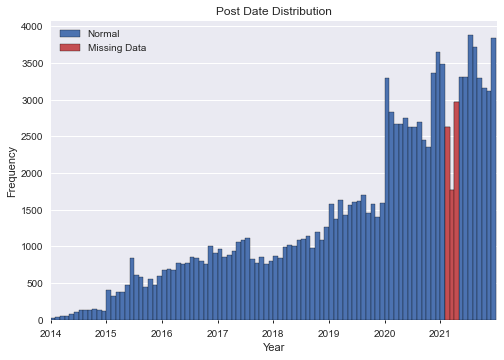

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)

pa.numsBinned['DATE']['ALL'].plot.bar(width=1.0, ec='k')

# Mark some bars as having missing data
missing = ((2021, 2), (2021, 3), (2021, 4))
missingIndices = getDateIndices(missing, pa.numsBinned['DATE']['ALL'])
plt.bar(missingIndices, 
        [pa.numsBinned['DATE']['ALL'].iloc[i] for i in missingIndices], 
        width=1.0, label='Missing Data', color=plt.rcParams['axes.prop_cycle'].by_key()['color'][2], ec='k')

plt.title('Post Date Distribution')
plt.xlabel('Year')
plt.ylabel('Frequency')
xtickDates(pa.numsBinned['DATE']['ALL'], ax)

plt.grid(axis='y')
ax.set_xlim(left=13.5)
plt.legend(['Normal', 'Missing Data'])

plt.savefig('./figures/post date distribution.png')

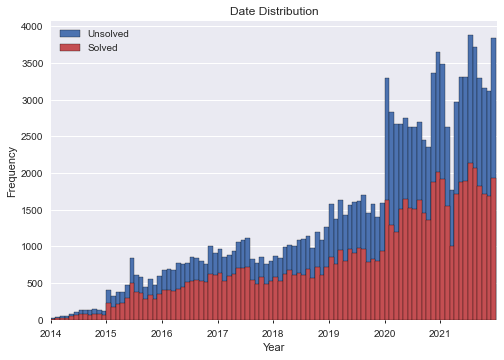

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)

pa.numsBinned['DATE']['ALL'].plot.bar(width=1.0, ec='k')
pa.numsBinned['DATE']['SOLVED'].plot.bar(color=plt.rcParams['axes.prop_cycle'].by_key()['color'][2], width=1.0, ec='k')

plt.title('Date Distribution')
plt.xlabel('Year')
plt.ylabel('Frequency')
xtickDates(pa.numsBinned['DATE']['ALL'], ax)

plt.legend(['Unsolved', 'Solved'])
plt.grid(axis='y')
ax.set_xlim(left=13.5)

plt.savefig('./figures/solved vs date distribution.png')

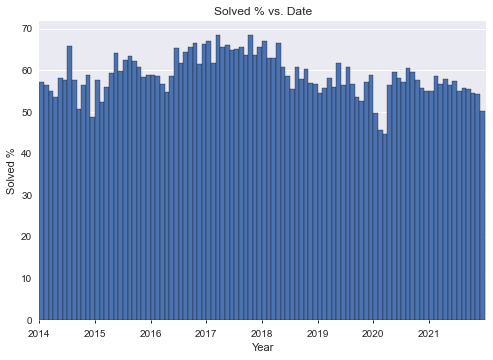

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)

pa.numsBinned['DATE']['SOLVED%'].plot.bar(width=1.0, ec='k')

plt.title('Solved % vs. Date')
plt.xlabel('Year')
plt.ylabel('Solved %')
xtickDates(pa.numsBinned['DATE']['ALL'], ax)

plt.grid(axis='y')
ax.set_xlim(left=13.5)

plt.savefig('./figures/solved percent vs date.png')

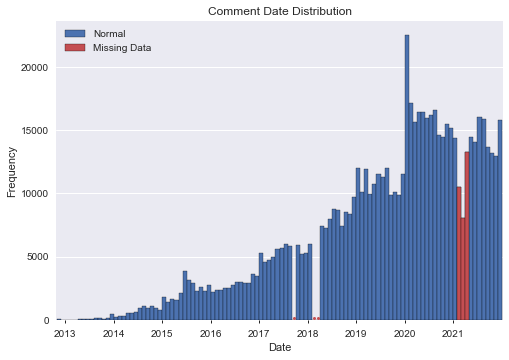

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)

ca.monthlyCommentCounts.plot.bar(width=1.0, ec='k', label='Normal')

# Mark some bars as having missing data
missing = ((2021, 2), (2021, 3), (2021, 4))
missingIndices = getDateIndices(missing, ca.monthlyCommentCounts)
plt.bar(missingIndices, 
        [ca.monthlyCommentCounts.iloc[i] for i in missingIndices], 
        width=1.0, label='Missing Data', color=plt.rcParams['axes.prop_cycle'].by_key()['color'][2], ec='k')
    
# Now for the completely missing bars
missing = ((2017, 9), (2018, 2), (2018, 3))
missingIndices = getDateIndices(missing, ca.monthlyCommentCounts)
for i in missingIndices:
    plt.plot(i, 150, 'o', color=plt.rcParams['axes.prop_cycle'].by_key()['color'][2], markersize=3)

plt.title('Comment Date Distribution')
plt.xlabel('Date')
plt.ylabel('Frequency')
xtickDates(ca.monthlyCommentCounts, ax)
plt.legend()

plt.grid(axis='y')

plt.savefig('./figures/comment date distribution.png')

### Score

count    131295.000000
mean          4.578468
std          11.464977
min           0.000000
25%           2.000000
50%           3.000000
75%           4.000000
max         540.000000
Name: SCORE, dtype: float64
Median: 3.0


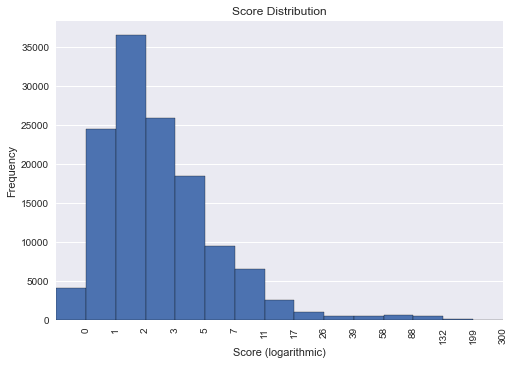

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)

print(pa.data.SCORE.describe())
print('Median:', pa.data.SCORE.median())

pa.numsBinned['SCORE']['ALL'].plot.bar(width=1.0, ec='k')

plt.title('Score Distribution')
plt.xlabel('Score (logarithmic)')
plt.ylabel('Frequency')
plt.xticks(np.arange(1, len(pa.bins['SCORE']))-0.5, pa.bins['SCORE'][1:])

plt.grid(axis='y')
ax.set_xlim(left=-0.5, right=len(pa.bins['SCORE'])-1.5)

plt.savefig('./figures/score distribution.png')

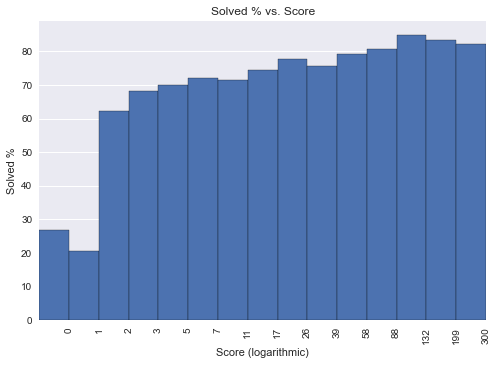

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)

pa.numsBinned['SCORE']['SOLVED%'].plot.bar(width=1.0, ec='k')

plt.title('Solved % vs. Score')
plt.xlabel('Score (logarithmic)')
plt.ylabel('Solved %')
plt.xticks(np.arange(1, len(pa.bins['SCORE']))-0.5, pa.bins['SCORE'][1:])

plt.grid(axis='y')
ax.set_xlim(left=-0.5, right=len(pa.bins['SCORE'])-1.5)

plt.savefig('./figures/solved percent vs score.png')

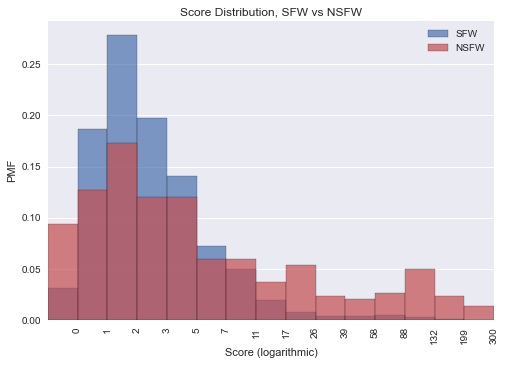

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
# pa.numsBinned['SCORE']['ALL'].plot.bar(width=1.0, ec='k', logy=True)
# pa.numsBinned['SCORE']['NSFW'].plot.bar(width=1.0, color='r', ec='k', logy=True)

pa.numsBinned['SCORE']['SFW'] = pa.numsBinned['SCORE']['ALL'] - pa.numsBinned['SCORE']['NSFW']

dists = ((pa.numsBinned['SCORE']['SFW'], 
          plt.rcParams['axes.prop_cycle'].by_key()['color'][0]), 
         
         (pa.numsBinned['SCORE']['NSFW'], 
          plt.rcParams['axes.prop_cycle'].by_key()['color'][2]))

for dist, c in dists:
    normalized = dist / sum(dist)
    normalized.plot.bar(width=1.0, ec='k', color=c, alpha=0.7)

plt.title('Score Distribution, SFW vs NSFW')
plt.xlabel('Score (logarithmic)')
plt.ylabel('PMF')
plt.xticks(np.arange(1, len(pa.bins['SCORE']))-0.5, pa.bins['SCORE'][1:])

plt.grid(axis='y')
ax.set_xlim(left=-0.5, right=len(pa.bins['SCORE'])-1.5)
plt.legend(['SFW', 'NSFW'])

plt.savefig('./figures/nsfw vs score.png')

### Length

count    131295.000000
mean        717.492517
std         539.013217
min           0.000000
25%         370.000000
50%         589.000000
75%         912.000000
max       10901.000000
Name: LENGTH, dtype: float64
Median: 589.0


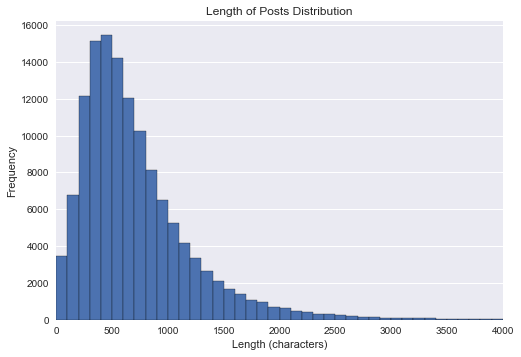

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111)

print(pa.data.LENGTH.describe())
print('Median:', pa.data.LENGTH.median())

pa.data.LENGTH.plot.hist(bins=pa.bins['LENGTH'], ec='k')

plt.title('Length of Posts Distribution')
plt.xlabel('Length (characters)')
plt.ylabel('Frequency')

plt.grid(axis='y')
ax.set_xlim(left=0, right=(len(pa.bins['LENGTH'])-1)*100)

plt.savefig('./figures/length distribution.png')

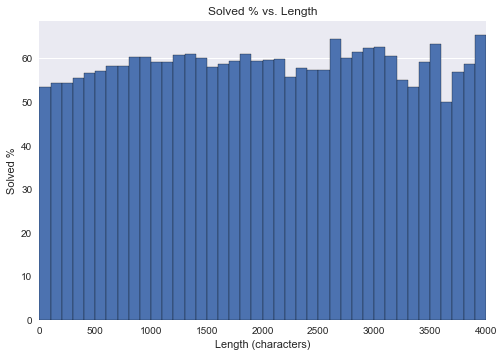

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111)

hist1, bins1 = np.histogram(pa.data.LENGTH, bins=pa.bins['LENGTH'])
hist2, bins2 = np.histogram(pa.data.LENGTH[pa.data.SOLVED == True], bins=pa.bins['LENGTH'])

width = bins1[1] - bins1[0]
plt.bar(bins1[:-1] + width/2, hist2 / hist1 * 100, width=width, ec='k')

plt.title('Solved % vs. Length')
plt.xlabel('Length (characters)')
plt.ylabel('Solved %')

plt.grid(axis='y')
ax.set_xlim(left=0, right=(len(pa.bins['LENGTH'])-1)*100)

plt.savefig('./figures/solved percent vs length.png')

### Num Comments

count    131295.000000
mean          4.908199
std           4.806868
min           0.000000
25%           2.000000
50%           4.000000
75%           6.000000
max         203.000000
Name: NUM_COMMENTS, dtype: float64
Median: 4.0


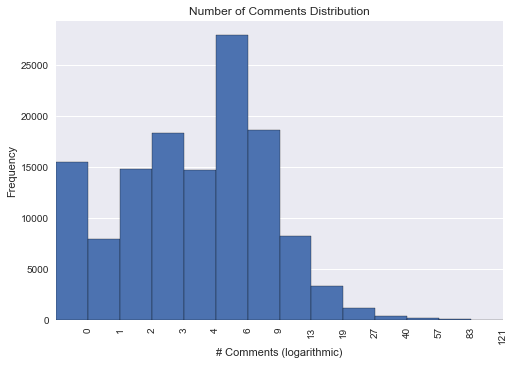

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)

print(pa.data.NUM_COMMENTS.describe())
print('Median:', pa.data.NUM_COMMENTS.median())

pa.numsBinned['NUM_COMMENTS']['ALL'].plot.bar(width=1.0, ec='k')

plt.title('Number of Comments Distribution')
plt.xlabel('# Comments (logarithmic)')
plt.ylabel('Frequency')
plt.xticks(np.arange(1, len(pa.bins['NUM_COMMENTS']))-0.5, pa.bins['NUM_COMMENTS'][1:])

plt.grid(axis='y')
ax.set_xlim(left=-0.5, right=len(pa.bins['NUM_COMMENTS'])-1.5)

plt.savefig('./figures/num comments distribution.png')

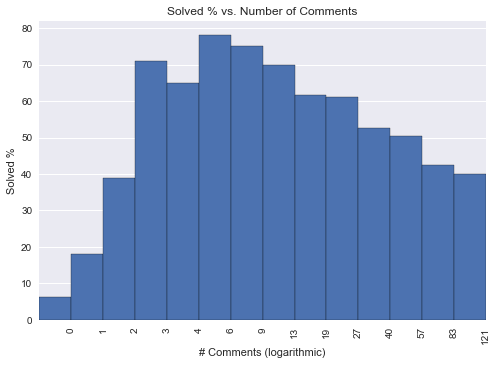

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)

pa.numsBinned['NUM_COMMENTS']['SOLVED%'].plot.bar(width=1.0, ec='k')

plt.title('Solved % vs. Number of Comments')
plt.xlabel('# Comments (logarithmic)')
plt.ylabel('Solved %')
plt.xticks(np.arange(1, len(pa.bins['NUM_COMMENTS']))-0.5, pa.bins['NUM_COMMENTS'][1:])

plt.grid(axis='y')
ax.set_xlim(left=-0.5, right=len(pa.bins['NUM_COMMENTS'])-1.5)

plt.savefig('./figures/solved percent vs num comments.png')

### Tables

In [21]:
# Solved vs. formatted (binary)
print()
print(pa.comparedBoolBool['SOLVED']['FOLLOWS_FORMAT'])


# solved vs. NSFW (binary)
print()
print(pa.comparedBoolBool['SOLVED']['NSFW'])


SOLVED              True     False
FOLLOWS_FORMAT                    
True            0.612833  0.387167
False           0.562189  0.437811

SOLVED      True     False
NSFW                      
True    0.632450  0.367550
False   0.574512  0.425488


### Platform

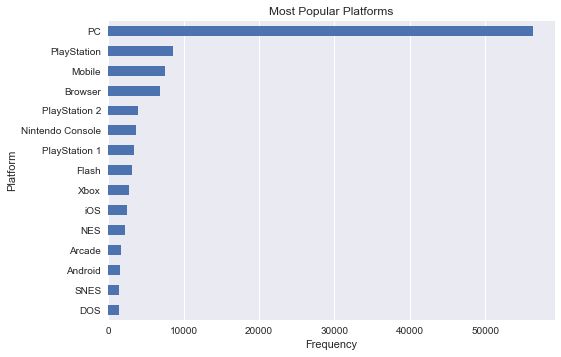

In [22]:
pa.platforms.sort_values(by='ALL', ascending=False)['ALL'].iloc[:15].plot.barh()

plt.title('Most Popular Platforms')
plt.ylabel('Platform')
plt.xlabel('Frequency')

plt.gca().invert_yaxis()
plt.grid(axis='x')

plt.savefig('./figures/platforms.png')

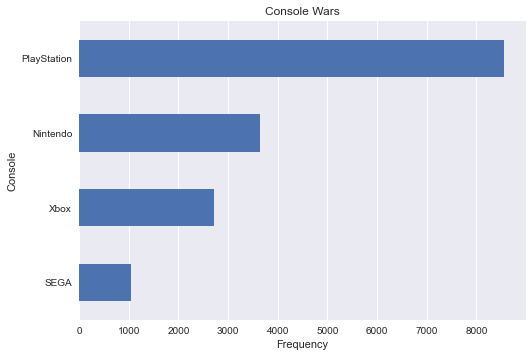

In [23]:
# Console wars
consoleBrands = pa.platforms.loc[['PlayStation', 'Xbox', 'Nintendo Console', 'SEGA Console']]
consoleBrands.rename(index={'Nintendo Console':'Nintendo', 'SEGA Console':'SEGA'}, inplace=True)
consoleBrands.sort_values(by='ALL', ascending=False)['ALL'].plot.barh()

plt.title('Console Wars')
plt.ylabel('Console')
plt.xlabel('Frequency')

plt.gca().invert_yaxis()
plt.grid(axis='x')

plt.savefig('./figures/console wars.png')

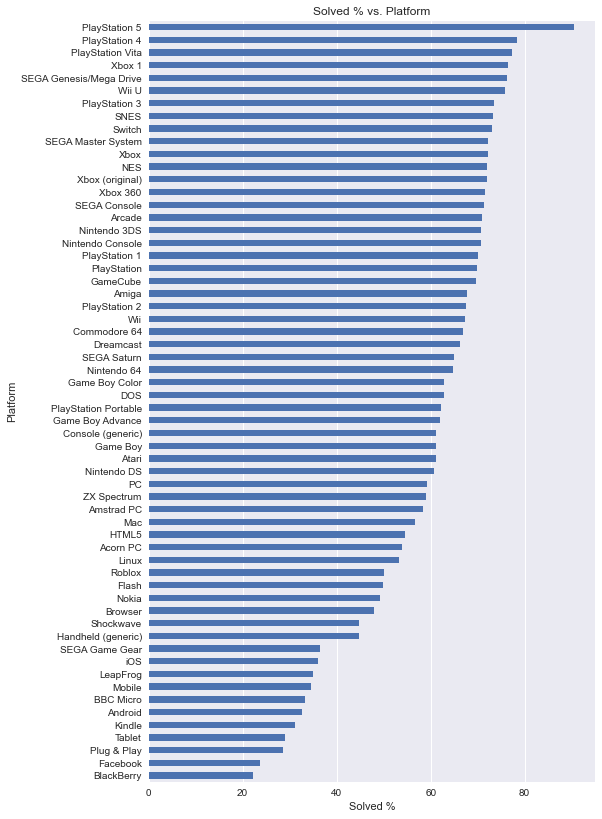

In [24]:
fig = plt.figure(figsize=(8, 14))
ax = fig.add_subplot(111)

# Remove platforms with very low numbers of posts
solvedAdjusted = pa.platforms[pa.platforms['ALL'] >= 10]

solvedAdjusted['SOLVED%'].plot.barh()

plt.title('Solved % vs. Platform')
plt.ylabel('Platform')
plt.xlabel('Solved %')

plt.gca().invert_yaxis()
plt.grid(axis='x')

plt.savefig('./figures/solved percent vs platform.png')

### Played Year

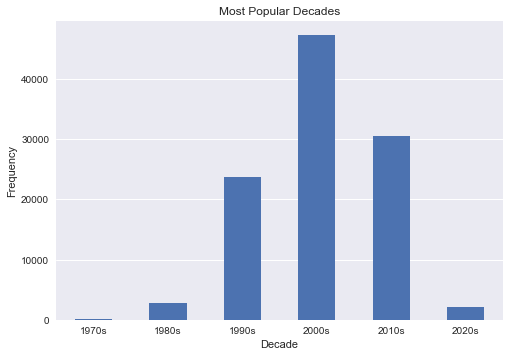

In [25]:
pa.years['ALL'].plot.bar()

plt.title('Most Popular Decades')
plt.xlabel('Decade')
plt.ylabel('Frequency')
plt.xticks(rotation=0)

plt.grid(axis='y')

plt.savefig('./figures/decades.png')

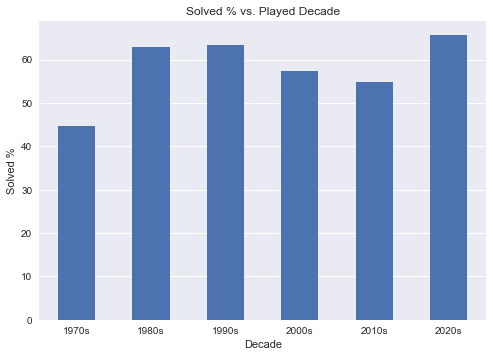

In [26]:
pa.years['SOLVED%'].plot.bar()

plt.title('Solved % vs. Played Decade')
plt.xlabel('Decade')
plt.ylabel('Solved %')
plt.xticks(rotation=0)

plt.grid(axis='y')

plt.savefig('./figures/solved percent vs decade.png')

## Games

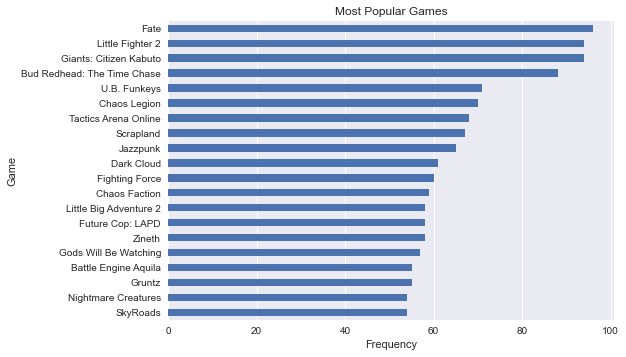

In [27]:
flairsLower = pa.data.FLAIR.dropna().apply(lambda s: s.lower())

gamesCount = flairsLower.value_counts().iloc[:20]
gamesCount.plot.barh()

# Gets the probable actual case from a lowercase version
def getProperCase(flair):
    i = flairsLower[flairsLower == flair].index[0]
    return pa.data.FLAIR.iloc[i]

gamesProperCase = []
for index in gamesCount.index:
    gamesProperCase.append(getProperCase(index))
plt.yticks(range(len(gamesProperCase)), gamesProperCase)

plt.title('Most Popular Games')
plt.ylabel('Game')
plt.xlabel('Frequency')

plt.gca().invert_yaxis()
plt.grid(axis='x')

plt.savefig('./figures/games.png')

### Top Commenters

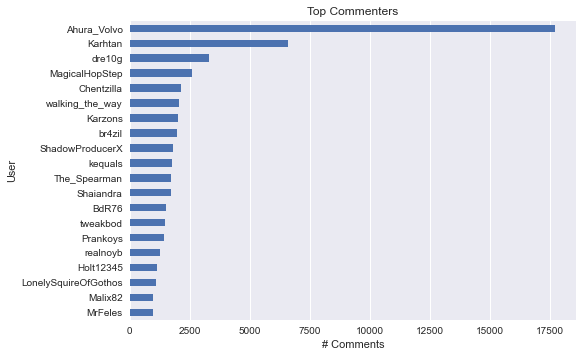

In [28]:
ca.commenters.iloc[:20].plot.barh()

plt.title('Top Commenters')
plt.ylabel('User')
plt.xlabel('# Comments')

plt.gca().invert_yaxis()
plt.grid(axis='x')

plt.savefig('./figures/commenters.png')

In [29]:
diff = pa.data.DATE.diff(periods=1)
thresholdDiff = diff[diff < pd.Timedelta('-1d')]
thresholdData = pa.data[pa.data.DATE.diff(periods=1) < pd.Timedelta('-1d')]

merged = thresholdData.merge(thresholdDiff, how='outer', left_index=True, right_index=True)

merged[merged.DATE_x > pd.Timestamp('2021')]

,ID,TITLE,USER,TEXT,FLAIR,DATE_x,SCORE,NUM_COMMENTS,NSFW,LENGTH,FOLLOWS_FORMAT,SOLVED,DATE_y
29551,mnqy07,[PC][Late 00's - Early 10's] 3d Edutainment Ma...,MagicalMelancholy,NaN,Timez Attack,2021-04-09,2,5,False,2610,False,True,-5 days
31033,m74f2v,[ps2-ps1] [2000-2005] Japanese horror game sim...,lelalalela14,NaN,NaN,2021-03-17,2,3,False,875,False,False,-10 days
32054,ly9glc,[PC] [CD-ROM][2000's] 2D Platformer where you ...,Idk_a_name_to_use69,NaN,NaN,2021-03-05,3,4,False,460,False,False,-2 days
32363,lu7l8d,[TV Game] [Mid 2000s] Plug-in game where you c...,Lucky_Improvement_15,NaN,Jibbi,2021-02-28,3,8,False,845,False,True,-2 days
34544,lcrlds,[PC] [1998-2002] Little man jumping over Soda ...,MrBaqoo,NaN,Mr. Tiny Adventures,2021-02-04,2,3,False,938,True,True,-3 days


In [30]:
diff = ca.data.DATE.diff(periods=1)
thresholdDiff = diff[diff < pd.Timedelta('-1d')]
thresholdData = ca.data[ca.data.DATE.diff(periods=1) < pd.Timedelta('-1d')]

thresholdData.merge(thresholdDiff, how='outer', left_index=True, right_index=True)

,ID,USER,DATE_x,DATE_y
124559,gtz04fe,Lazytron,2021-04-09,-5 days
131223,gr9545t,LolcatP,2021-03-17,-10 days
136031,gppw6gw,thifofdeath,2021-03-05,-2 days
137162,goy4i21,Creative-Brief267,2021-02-27,-3 days
146115,glwagt7,Wolff_Hound,2021-02-03,-4 days
149665,gkjkgh8,Ahura_Volvo,2021-01-24,-3 days
190438,gb66qmr,Ahura_Volvo,2020-11-04,-2 days
563406,dtjnzi7,conquer69,2018-01-31,-60 days
585871,dmehjn5,walking_the_way,2017-08-31,-31 days
698256,cew551m,hyawatha15,2014-01-22,-2 days
